In [1]:
import numpy as np
from sympy import *
from sympy.solvers import solve
import warnings
from scipy.linalg import solve_continuous_lyapunov
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning) 
init_printing(use_unicode=True)

In [2]:
def simulate_M(seed: int, p: int) -> Array:
    np.random.seed(seed=seed)
    normal_matrix = np.random.normal(0, 1, (p, p))
    for i in range(p): # adjust diagonal entries s.t. M stable
        normal_matrix[i, i] = - np.sum(np.abs(normal_matrix[i, :]))
    return normal_matrix

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def create_A_Sigma(cov: Array, p: int) -> Array:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = np.empty(shape=(row_num, col_num), dtype=float)
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Array, mean: Array, p: int) -> Array:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = np.hstack((identity, mean[i] * eye(p)))
    return np.vstack((A_Sigma, identity))

In [3]:
def solve_lyapunov_cov(M: Matrix, C: Matrix, p: int) -> Matrix:
    Sigma = MatrixSymbol("Sigma", p, p).as_explicit()
    Sigma_solved = solve(M*Sigma + Sigma*M.T + C, Sigma)
    scheme = [[Sigma_solved[Sigma[i,j]] for i in range(p)] for j in range(p)]
    Sigma_new = Matrix(scheme)
    return Sigma_new

def create_A_Sigma_sympy(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A_sympy(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

def create_c_sympy(vech_C: Matrix, b: float, index: int, p: int) -> Matrix:
    unit_vector = eye(p).col(index)
    return Matrix.vstack(vech_C, - b * unit_vector)

## Example for fully connected graph on 3 nodes
The corresponding drift matrix is given by $M = \begin{pmatrix} m_{11} & m_{12} & m_{13}\\ m_{21} & m_{22} & m_{23}\\ m_{31} & m_{32} & m_{33}\end{pmatrix}$. Let's choose this matrix randomly to be a stable matrix, generate 1000 instances of the underlying process and apply Lasso regression with parameter $\lambda = 0.001$ as seen in the package 'sklearn'. We suppose an intervention on the first node with a shift parameter $b=2$.

In [4]:
p = 3
num_sim = 1000 # number of simulations
index_intervention = 0
b = 2

C = 2 * np.eye(p)
vech_C = np.array([C[i, j] for i in range(p) for j in range(i, p)])
unit_v = np.eye(p)[:, index_intervention]
c = np.hstack((vech_C, - b * unit_v))

reg_param = 0.001

true_M = simulate_M(seed=12, p=p)
true_M

array([[-1.39685121, -0.68142588,  0.2424395 ],
       [-1.70073563, -3.98859981, -1.53472134],
       [ 0.00512708, -0.12022767, -0.93233663]])

In [5]:
true_cov = solve_continuous_lyapunov(a=true_M, q=-C)
true_mean = (b * np.linalg.inv(a=true_M)).dot(unit_v)

obs = np.random.multivariate_normal(mean = true_mean, cov = true_cov, size = num_sim)
emp_cov = np.cov(obs, rowvar=False)
emp_mean = np.mean(obs, axis=0)

emp_A_Sigma = create_A_Sigma(cov=emp_cov, p=p)
emp_A = create_A(A_Sigma=emp_A_Sigma, mean=emp_mean, p=p)

direct_lasso = linear_model.Lasso(alpha=reg_param, max_iter=5000)
direct_lasso.fit(X=emp_A, y=-c)
est_M = np.transpose(np.reshape(direct_lasso.coef_, shape=(p, p)))
frob = np.linalg.norm(est_M - true_M)
print(frob)
est_M

0.9883564827737027


array([[-1.14643722, -0.        ,  0.551987  ],
       [-1.47765782, -3.49275742, -1.33852597],
       [-0.00353736, -0.        , -0.85929751]])

Now let's look at the symbolic computation with 'sym_py'.

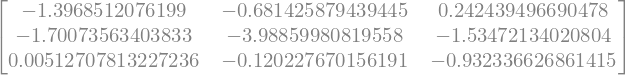

In [6]:
m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])
unit_v = eye(p).col(index_intervention)

subs = {m11: true_M[0, 0], m12: true_M[0, 1], m13: true_M[0, 2], m21: true_M[1, 0], m22: true_M[1, 1], m23: true_M[1, 2], m31: true_M[2, 0], m32: true_M[2, 1], m33: true_M[2, 2]}
concrete_M = M.subs(subs)
concrete_M

8.068330095695664


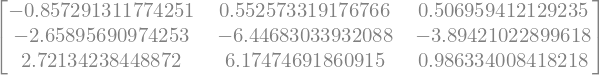

In [7]:
cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
mean = b * concrete_M.inv() * unit_v

A_Sigma = create_A_Sigma_sympy(cov=cov, p=p)
A = create_A_sympy(A_Sigma=A_Sigma, mean=mean, p=p)

c = create_c_sympy(vech_C=vech_C, b=b, index=index_intervention, p=p)

det_A = det(A)
solution = solve(A * vec_M + c, vec_M)

if len(solution) == 9:
    M_est = M.subs(solution)
    M_est_np = matrix2numpy(M_est).astype(float)
    M_true = matrix2numpy(concrete_M).astype(float)
    frob = np.linalg.norm(M_est_np - M_true)

print(frob)
M_est